In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import newmodel
import diffmodel
import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import importlib 
importlib.reload(diffmodel)

<module 'diffmodel' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/diffmodel.py'>

In [3]:
dir = '../data/simulated/'

path = '2b5c_sigma0.1_b1_1/' #'2b5c_ziqi1/'

counts_rna = pd.read_csv(os.path.join(dir + path, 'GxC1.txt'), sep = "\t", header = None).values.T
counts_atac = pd.read_csv(os.path.join(dir + path, 'RxC2.txt'), sep = "\t", header = None).values.T
A = pd.read_csv(os.path.join(dir + path, 'region2gene.txt'), sep = "\t", header = None).values.T

counts_rna = np.array(counts_rna)
counts_atac = np.array(counts_atac)
A = np.array(A)


label_rna = pd.read_csv(os.path.join(dir + path, "cell_label1.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir + path, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

# counts_atac = counts_atac[np.where(label_atac != 1)[0],:]
# label_atac = label_atac[np.where(label_atac != 1)[0]]

counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


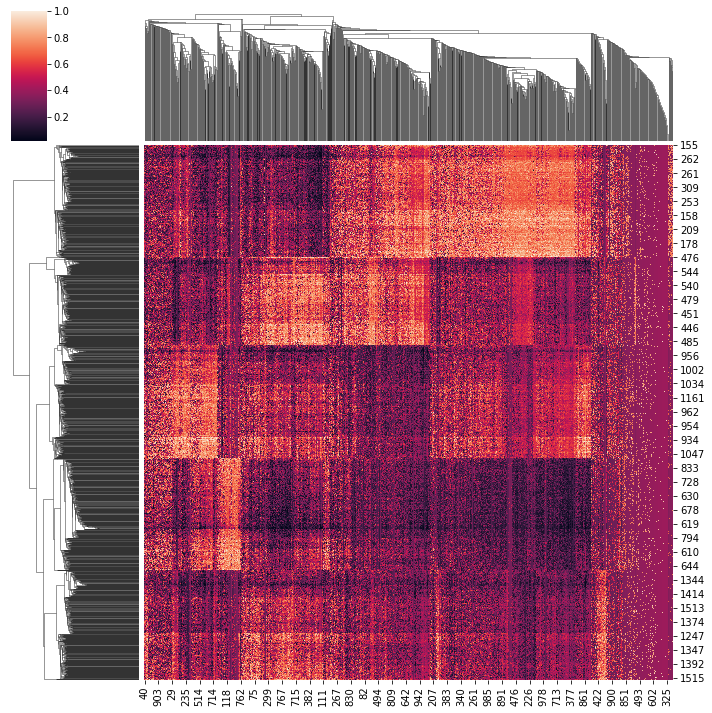

In [13]:
import seaborn as sns
sns.clustermap(model1.G.detach().cpu().numpy())

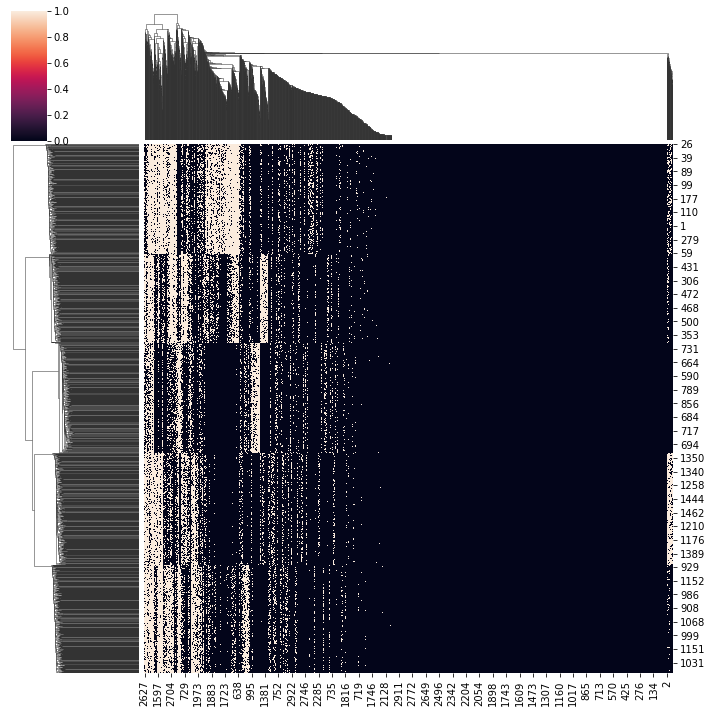

In [15]:
import seaborn as sns
sns.clustermap(model1.R.detach().cpu().numpy())

In [4]:
# train model
alpha = [1000, 1000, 100, 100, 1, 2, 0, 0]
model1 = diffmodel.cfrm_diff(counts, N1 = 5, N2 = 5, K = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha =alpha, seed = 0, learn_gact = False).to(device)

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load(f'../check_points/real_5.pt'))

Epoch 100, Validating Loss: -97.5826
	 loss 1: 34.62692
	 loss 2: 58.79533
	 loss 3: -93.95880
	 loss 4: -97.04604
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.708569049835205
Epoch 200, Validating Loss: -103.9571
	 loss 1: 34.64240
	 loss 2: 58.79552
	 loss 3: -99.01152
	 loss 4: -98.38348
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.5177738666534424
Epoch 300, Validating Loss: -105.5731
	 loss 1: 34.58689
	 loss 2: 58.76083
	 loss 3: -99.86337
	 loss 4: -99.05741
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.5176646709442139
Epoch 400, Validating Loss: -106.0494
	 loss 1: 34.61528
	 loss 2: 58.70596
	 loss 3: -99.98701
	 loss 4: -99.38362
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.5178329944610596
Epoch 500, Validating Loss: -106.3955
	 loss 1: 34.58866
	 loss 2: 58.54724
	 loss 3: -99.99903
	 loss 4: -99.53237
	 loss 5: 0.00

Epoch 4100, Validating Loss: -149.8347
	 loss 1: 19.40178
	 loss 2: 34.81378
	 loss 3: -99.99906
	 loss 4: -98.45392
	 loss 5: 0.00000
	 loss 6: -5.59732
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4200, Validating Loss: -149.9469
	 loss 1: 19.36866
	 loss 2: 34.76917
	 loss 3: -99.99920
	 loss 4: -98.47266
	 loss 5: 0.00000
	 loss 6: -5.61288
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4300, Validating Loss: -150.0292
	 loss 1: 19.36016
	 loss 2: 34.73642
	 loss 3: -99.99934
	 loss 4: -98.49916
	 loss 5: 0.00000
	 loss 6: -5.62732
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4400, Validating Loss: -150.1081
	 loss 1: 19.33992
	 loss 2: 34.71464
	 loss 3: -99.99939
	 loss 4: -98.52260
	 loss 5: 0.00000
	 loss 6: -5.64066
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4500, Validating Loss: -150.1709
	 loss 1: 19.33160
	 loss 2: 34.69873
	 loss 3: -99.99940
	 loss 4: -98.54833
	 loss 5: 0.00000
	 loss 6: -5.65353
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4600, Validating Loss: -150.2289
	 loss 1: 1

Epoch 8500, Validating Loss: -151.5069
	 loss 1: 19.25109
	 loss 2: 34.54129
	 loss 3: -99.99963
	 loss 4: -99.05811
	 loss 5: 0.00000
	 loss 6: -6.24156
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8600, Validating Loss: -151.5292
	 loss 1: 19.24942
	 loss 2: 34.54130
	 loss 3: -99.99963
	 loss 4: -99.07019
	 loss 5: 0.00000
	 loss 6: -6.25012
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8700, Validating Loss: -151.5537
	 loss 1: 19.24599
	 loss 2: 34.53942
	 loss 3: -99.99968
	 loss 4: -99.08132
	 loss 5: 0.00000
	 loss 6: -6.25815
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8800, Validating Loss: -151.5603
	 loss 1: 19.25538
	 loss 2: 34.54186
	 loss 3: -99.99969
	 loss 4: -99.09232
	 loss 5: 0.00000
	 loss 6: -6.26555
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8900, Validating Loss: -151.5912
	 loss 1: 19.24620
	 loss 2: 34.53451
	 loss 3: -99.99971
	 loss 4: -99.10005
	 loss 5: 0.00000
	 loss 6: -6.27211
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9000, Validating Loss: -151.6078
	 loss 1: 1

In [194]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

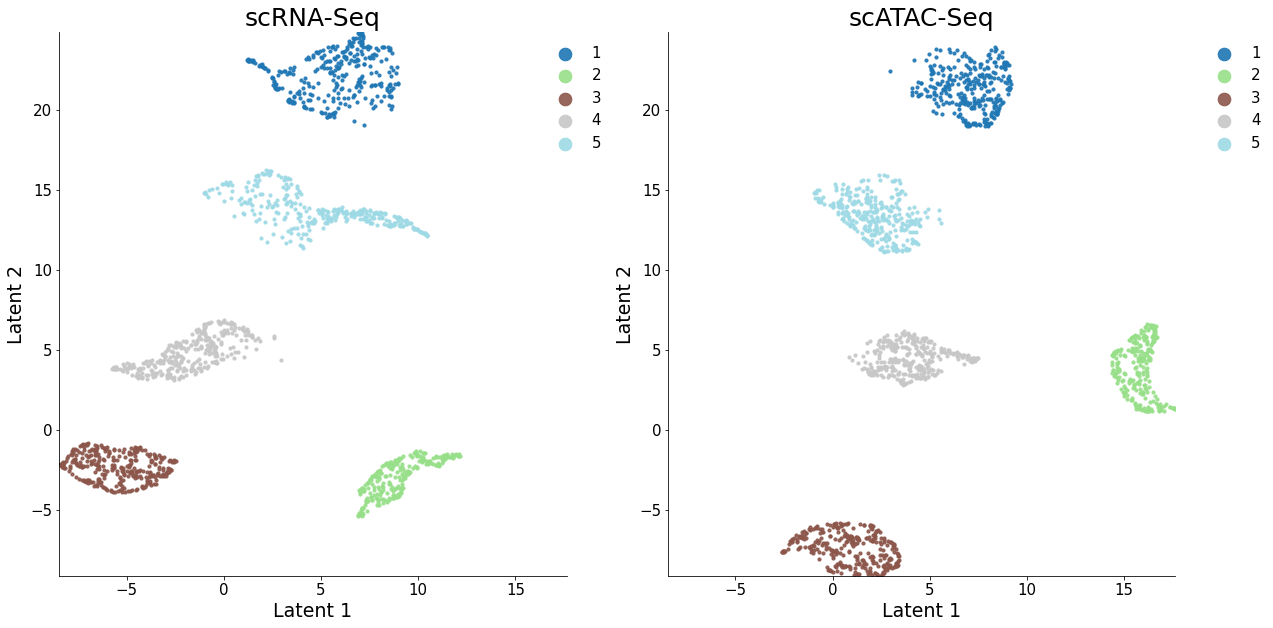

In [195]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

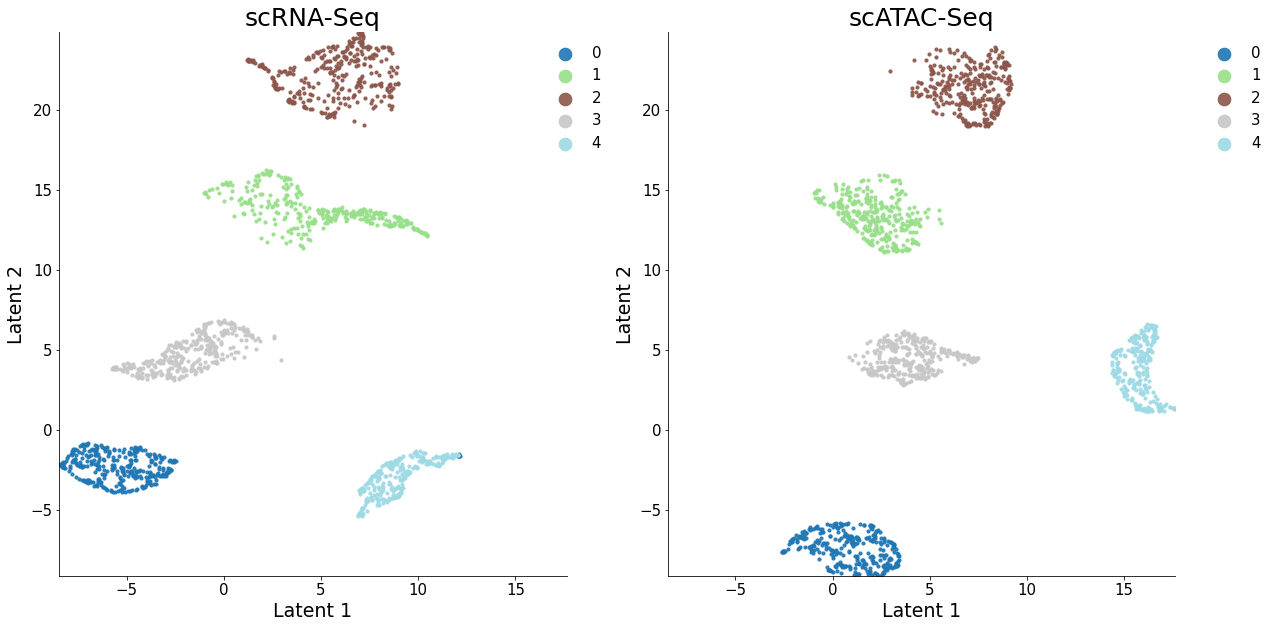

In [196]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

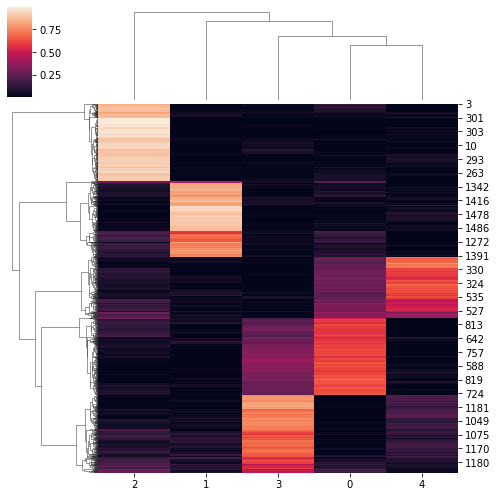

In [197]:
g = sns.clustermap(z_rna, figsize = (7,7))

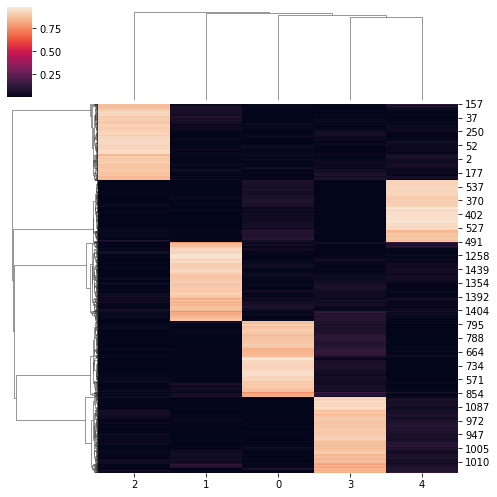

In [198]:
_ = sns.clustermap(z_atac, figsize = (7,7))

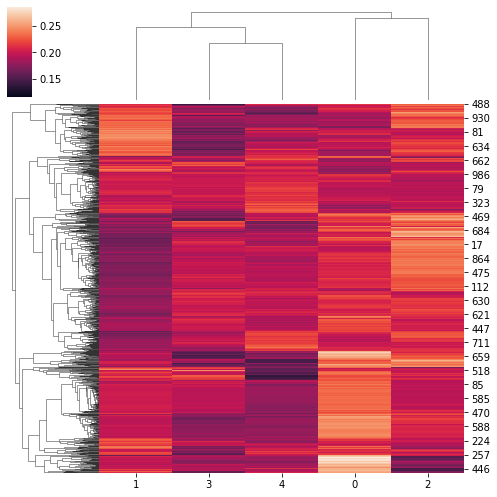

In [199]:
z_g = model1.softmax(model1.C_g).cpu().detach().numpy()
z_r = model1.softmax(model1.C_r).cpu().detach().numpy()
_ = sns.clustermap(z_g, figsize = (7,7))

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


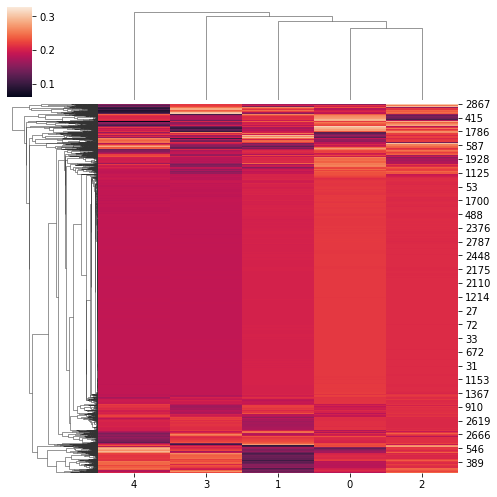

In [200]:
_ = sns.clustermap(z_r, figsize = (7,7))

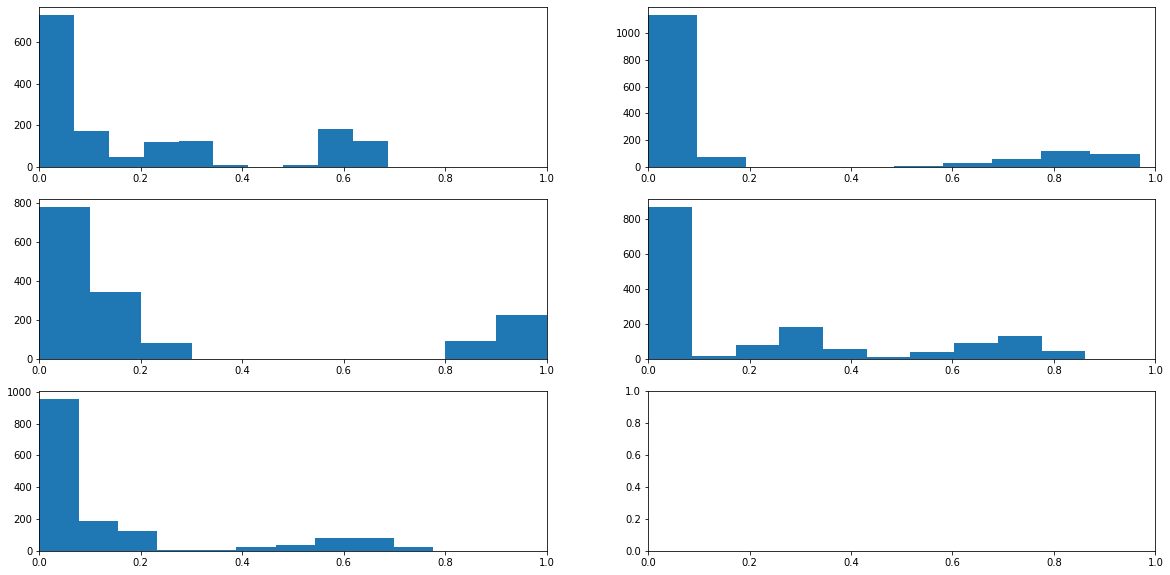

In [201]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])
_ = axs[2,0].hist(z_rna[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

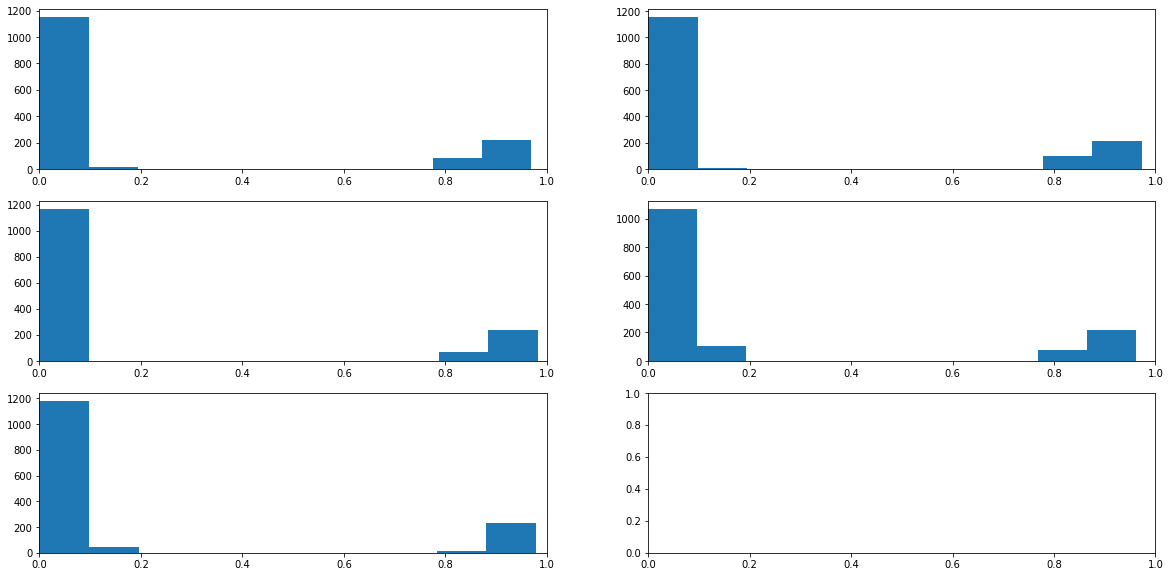

In [202]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])
_ = axs[2,0].hist(z_atac[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

In [136]:
# train model
alpha = [1000, 1000, 100, 100, 1, 0, 0, 0]
model2 = diffmodel.cfrm_diff(counts, N1 = 5, N2 = 5, K = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha =alpha, seed = 0, learn_gact = False).to(device)

model2.train_func(T = 10000)
# model1.load_state_dict(torch.load(f'../check_points/real_5.pt'))

Epoch 100, Validating Loss: -97.5826
	 loss 1: 34.62692
	 loss 2: 58.79533
	 loss 3: -93.95880
	 loss 4: -97.04604
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.440577745437622
Epoch 200, Validating Loss: -103.9571
	 loss 1: 34.64240
	 loss 2: 58.79552
	 loss 3: -99.01152
	 loss 4: -98.38348
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4375996589660645
Epoch 300, Validating Loss: -105.5731
	 loss 1: 34.58689
	 loss 2: 58.76083
	 loss 3: -99.86337
	 loss 4: -99.05741
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4374642372131348
Epoch 400, Validating Loss: -106.0494
	 loss 1: 34.61528
	 loss 2: 58.70596
	 loss 3: -99.98701
	 loss 4: -99.38362
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4383697509765625
Epoch 500, Validating Loss: -106.3955
	 loss 1: 34.58866
	 loss 2: 58.54724
	 loss 3: -99.99903
	 loss 4: -99.53237
	 loss 5: 0.00

Epoch 4100, Validating Loss: -144.1523
	 loss 1: 19.37149
	 loss 2: 34.86936
	 loss 3: -99.99944
	 loss 4: -98.39375
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4200, Validating Loss: -144.2711
	 loss 1: 19.33121
	 loss 2: 34.81011
	 loss 3: -99.99952
	 loss 4: -98.41286
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4300, Validating Loss: -144.3545
	 loss 1: 19.31851
	 loss 2: 34.76715
	 loss 3: -99.99960
	 loss 4: -98.44056
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4400, Validating Loss: -144.4291
	 loss 1: 19.29649
	 loss 2: 34.73718
	 loss 3: -99.99969
	 loss 4: -98.46307
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4500, Validating Loss: -144.4863
	 loss 1: 19.28654
	 loss 2: 34.71586
	 loss 3: -99.99969
	 loss 4: -98.48895
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 4600, Validating Loss: -144.5376
	 loss 1: 19.275

Epoch 8500, Validating Loss: -145.2482
	 loss 1: 19.19050
	 loss 2: 34.53121
	 loss 3: -99.99995
	 loss 4: -98.96996
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8600, Validating Loss: -145.2592
	 loss 1: 19.18821
	 loss 2: 34.53091
	 loss 3: -99.99995
	 loss 4: -98.97833
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8700, Validating Loss: -145.2725
	 loss 1: 19.18437
	 loss 2: 34.52807
	 loss 3: -99.99995
	 loss 4: -98.98495
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8800, Validating Loss: -145.2685
	 loss 1: 19.19275
	 loss 2: 34.53076
	 loss 3: -99.99993
	 loss 4: -98.99206
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 8900, Validating Loss: -145.2882
	 loss 1: 19.18288
	 loss 2: 34.52193
	 loss 3: -99.99995
	 loss 4: -98.99309
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
Epoch 9000, Validating Loss: -145.2951
	 loss 1: 19.181

In [139]:
z_rna = model2.softmax(model2.C_1).cpu().detach().numpy()
z_atac = model2.softmax(model2.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

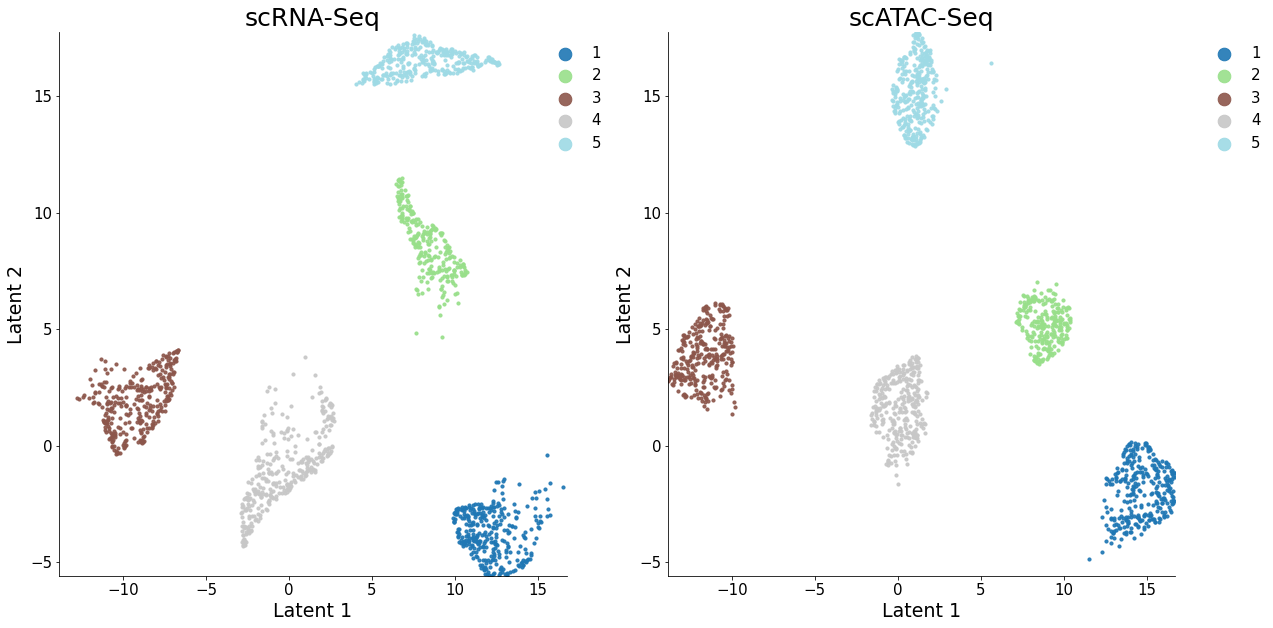

In [140]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

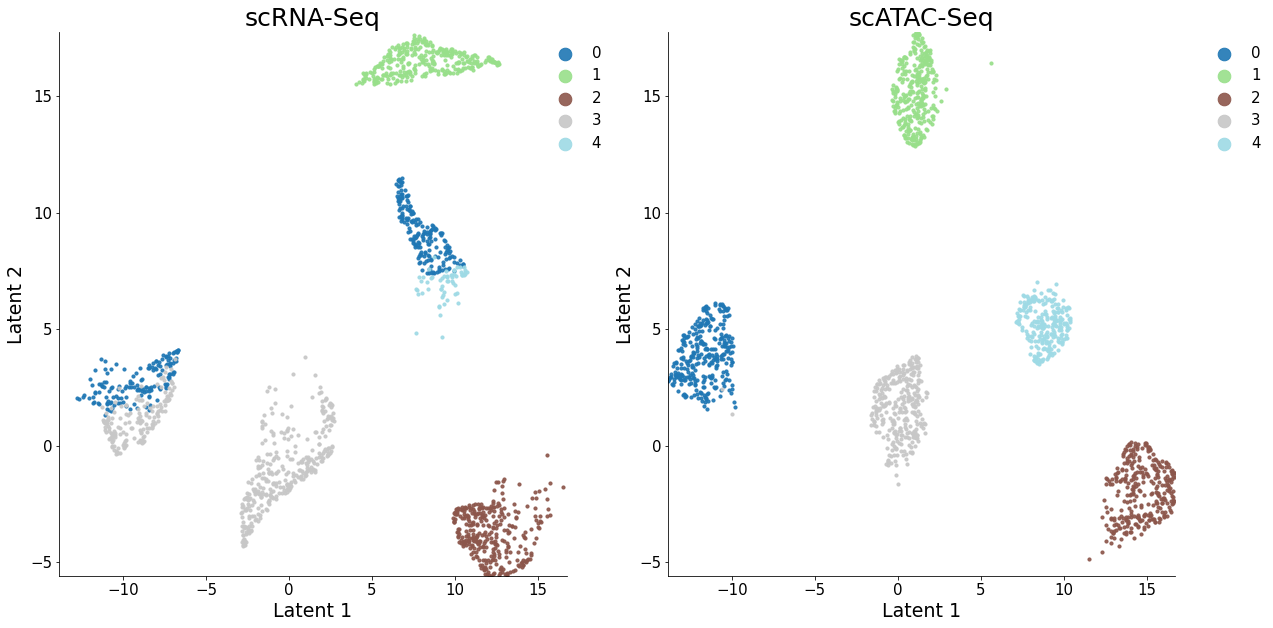

In [141]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

(0.0, 1.0)

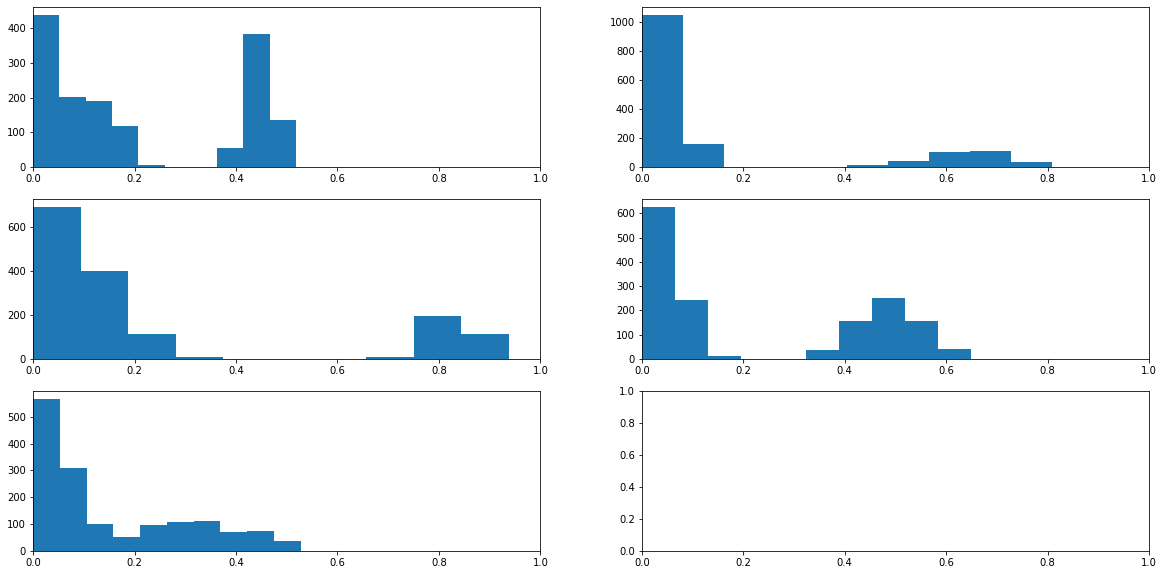

In [145]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])
_ = axs[2,0].hist(z_rna[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

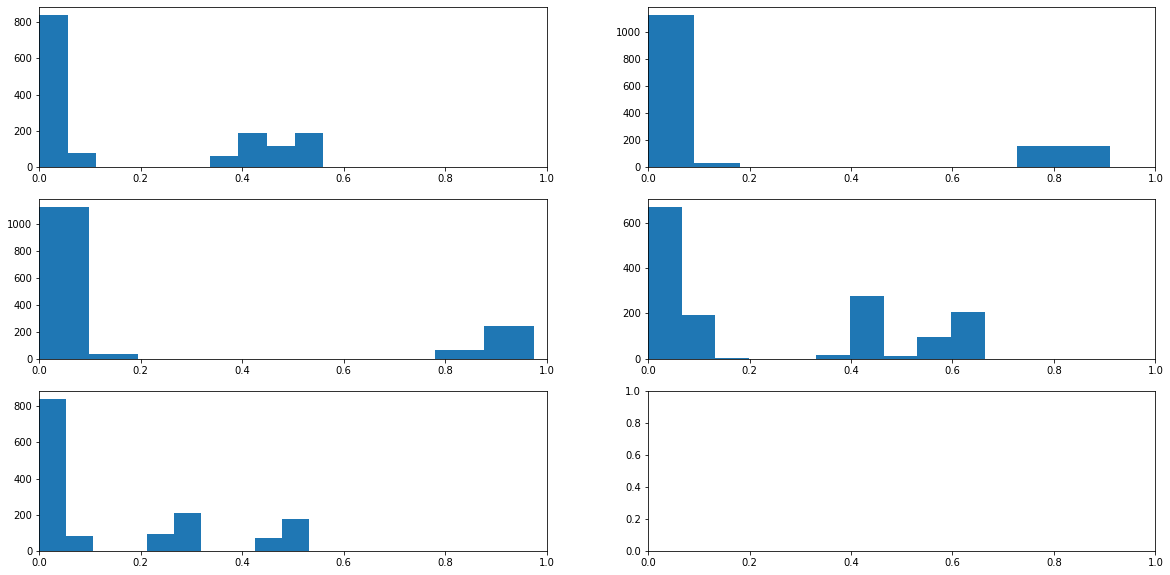

In [146]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])
_ = axs[2,0].hist(z_atac[:,4])

_ = axs[0,0].set_xlim([0,1])
_ = axs[0,1].set_xlim([0,1])
_ = axs[1,0].set_xlim([0,1])
_ = axs[1,1].set_xlim([0,1])
_ = axs[2,0].set_xlim([0,1])

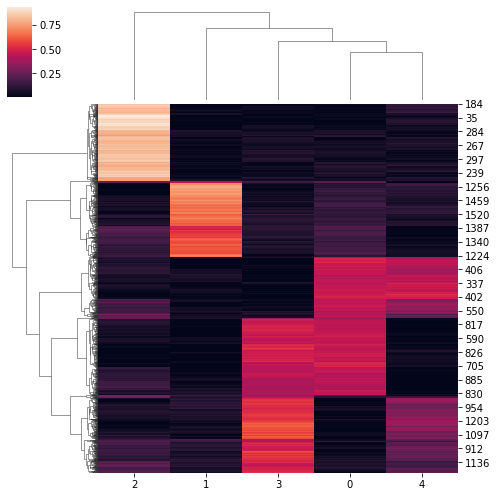

In [144]:
g = sns.clustermap(z_rna, figsize = (7,7))

In [16]:
dir = '../data/real/Xichen/small_ver'

counts_rna = sp.load_npz(os.path.join(dir, 'GxC1_small.npz'))
counts_atac = sp.load_npz(os.path.join(dir, 'RxC2_small.npz')).astype(np.float32)
A = sp.load_npz(os.path.join(dir, 'GxR_small.npz'))
subsample = 1

counts_rna = np.array(counts_rna.todense().T)
counts_atac = np.array(counts_atac.todense().T)
counts_rna = counts_rna[::subsample,:]
counts_atac = counts_atac[::subsample,:]
A = np.array(A.todense())

counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}


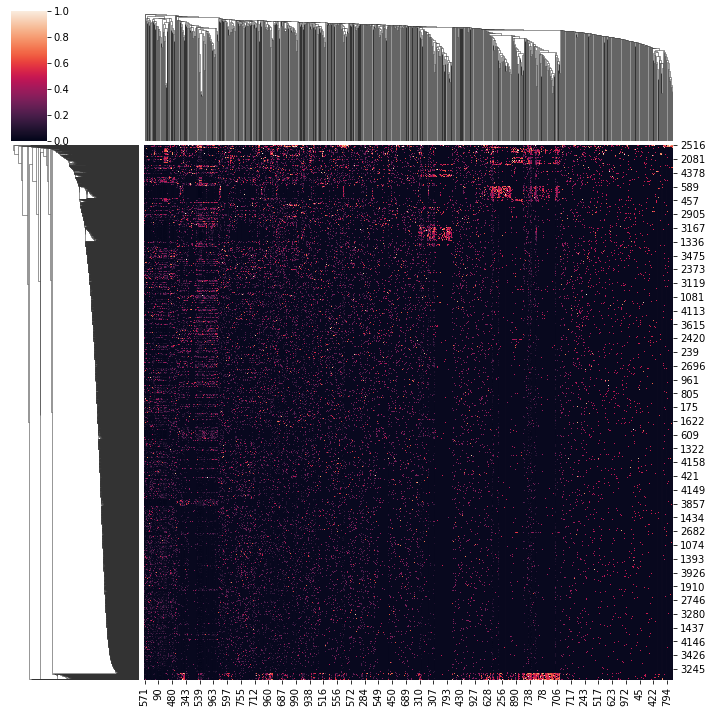

In [22]:
import seaborn as sns
sns.clustermap(model1.G.detach().cpu().numpy())

In [21]:
# train model
alpha = [1000, 1000, 100, 100, 1, 1, 0, 0]
# alpha = [1000, 1000, 100, 100, 1, 0, 0, 0]
model1 = diffmodel.cfrm_diff(counts, N1 = 13, N2 = 13, K = 13, batch_size = 0.1, interval=100, lr=1e-3, alpha = alpha, seed = 0, learn_gact = False).to(device)

model1.train_func(T = 10000)
# model1.load_state_dict(torch.load(f'../figures/2b5c_ziqi.pt'))

Epoch 100, Validating Loss: -95.2780
	 loss 1: 8.18115
	 loss 2: 80.54417
	 loss 3: -88.00507
	 loss 4: -95.99825
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4441967010498047
Epoch 200, Validating Loss: -105.5398
	 loss 1: 8.16359
	 loss 2: 80.51698
	 loss 3: -97.35142
	 loss 4: -96.86897
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.4422647953033447
Epoch 300, Validating Loss: -108.5084
	 loss 1: 8.16403
	 loss 2: 80.51879
	 loss 3: -99.59833
	 loss 4: -97.59290
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
	 loss 8: 0.00000
time cost: 1.7479987144470215


KeyboardInterrupt: 

In [ ]:
dir = '../data/real/Xichen'

z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
label_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)["cell_type"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)["cell_type"].values.squeeze()

In [ ]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

In [ ]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "hybrid", save = None)

In [208]:
z_rna = model1.softmax(model1.C_1).cpu().detach()
z_atac = model1.softmax(model1.C_2).cpu().detach()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

z_rna, z_atac = utils.match_alignment(z_rna, z_atac, k = 10)
# z_atac, z_rna = utils.match_alignment(z_atac, z_rna, k = 10)

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

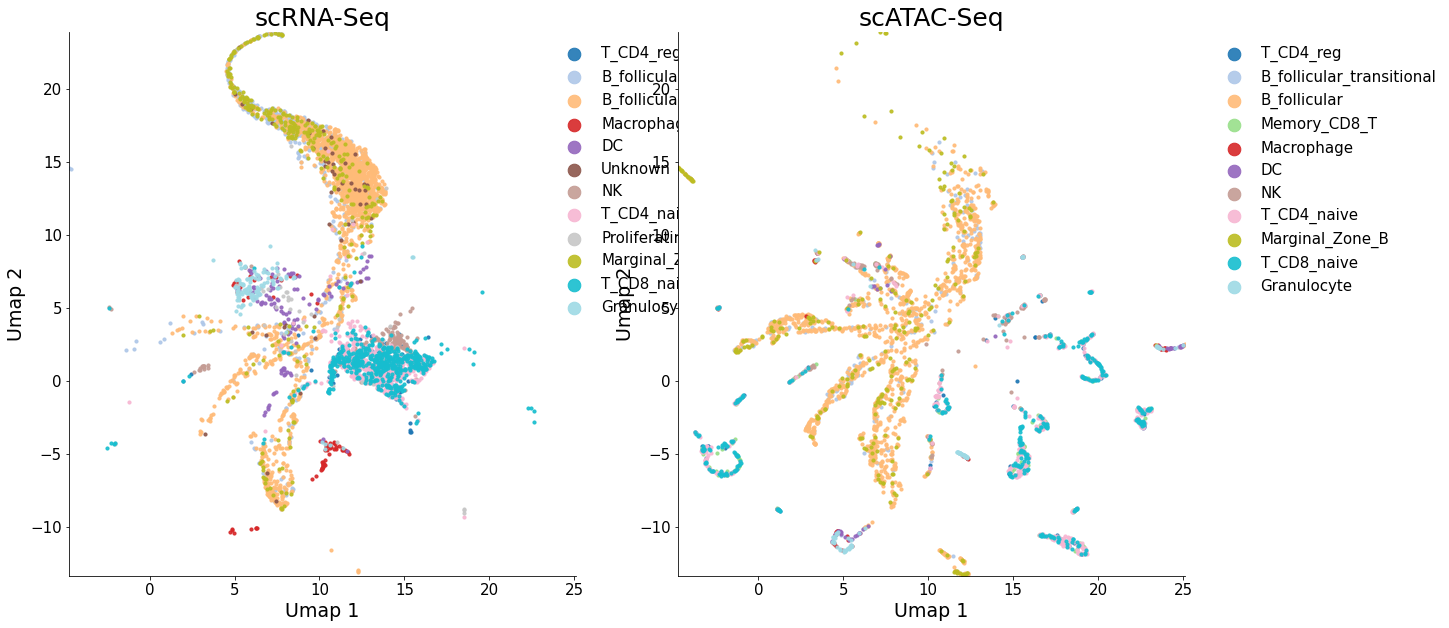

In [209]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", axis_label = "Umap", save = None)

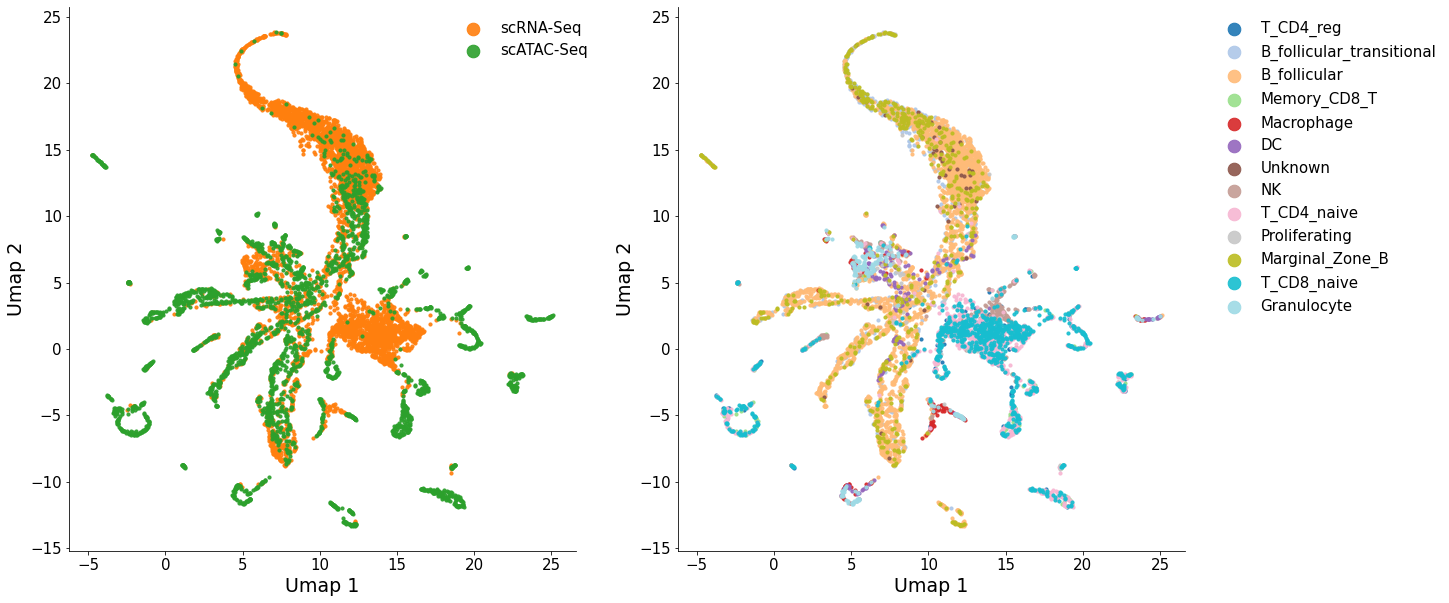

In [210]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "hybrid", axis_label = "Umap", save = None)

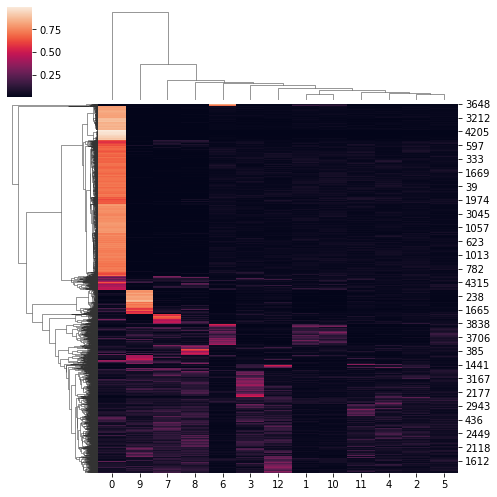

In [212]:
g = sns.clustermap(z_rna.numpy(), figsize = (7,7))

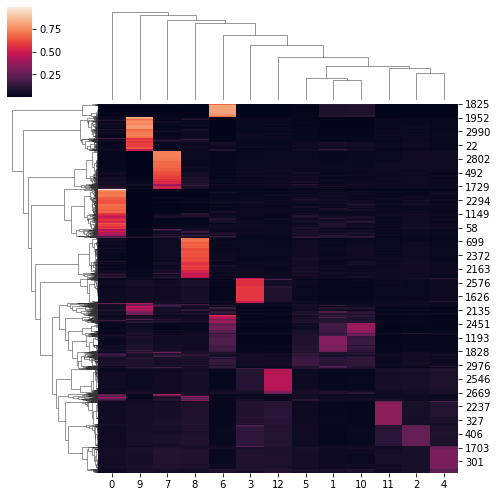

In [213]:
g = sns.clustermap(z_atac.numpy(), figsize = (7,7))